# Optical Flow
## Sparse Optical Flow

As always start by importing the relevant packages.

In [46]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils

Load the images "OF1.jpg" and "OF2.jpg" and change them to grayscale.

In [47]:
img1 = cv2.imread('1l.jpg')
img2 = cv2.imread('2l.jpg')

b,g,r = cv2.split(img1) # Changing the order from bgr to rgb so that matplotlib can show it
img1 = cv2.merge([r,g,b])
b,g,r = cv2.split(img2) # Changing the order from bgr to rgb so that matplotlib can show it
img2 = cv2.merge([r,g,b])

gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

plt.figure(figsize = (18,18))
plt.subplot(1,2,1)
plt.imshow(gray1, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(gray2, cmap = 'gray')

ValueError: not enough values to unpack (expected 3, got 0)

They look pretty much the same. We can now use optical flow to find out how the objects in the picutures have moved. We do this by first using [cv2.goodFeaturesToTrack](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) to find features in the first image. You can play around with the parameters to see the difference.

In [44]:
feat1 = cv2.goodFeaturesToTrack(gray1, maxCorners=100, qualityLevel=0.3, minDistance=7)

Next we use the function [cv2.calcOpticalFlowPyrLK](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323) to track the features in the next image.

In [45]:
feat2, status, error = cv2.calcOpticalFlowPyrLK(gray1, gray2, feat1, None)

We now have the location of the features from the first image in the second image. To find the movement we can draw a line between the keypoints.

## Dense Optical Flow
The sparse optical flow finds the flow of the detected keypoints. We will now try to use dense optical flow which, finds the flow of all the points in the picture. 
For this example we use the same two images, so we don't have to load them again. To find the optical flow we use the function [cv2.calcOpticalFlowFarneback](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Check out the description to see what all the different parameters does, and try to change them to see the difference.

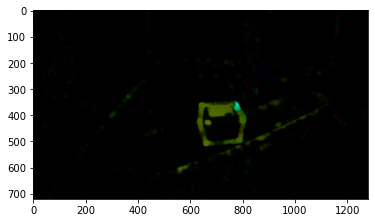

In [18]:
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.5, 0)
mag, angle =cv2.cartToPolar(flow[..., 0], flow[...,1])

mask=np.zeros_like(img1)

mask[...,1]=255
mask[...,0]= angle*180/np.pi/2
mask[...,2]=cv2.normalize(mag,None,0,255, cv2.NORM_MINMAX)

rgb= cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

plt.imshow(rgb)


Noise reduction by erosion and dialation

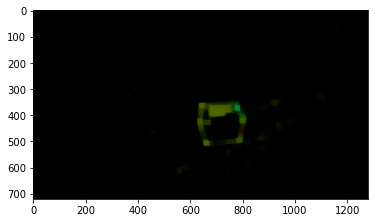

In [19]:
kernel=np.ones((5,5))
ero=cv2.erode(rgb,kernel, iterations=4)
plt.imshow(ero)
dia=cv2.dilate(ero,kernel,iterations=7)
ero2=cv2.erode(dia,kernel, iterations=3)
plt.imshow(ero2)

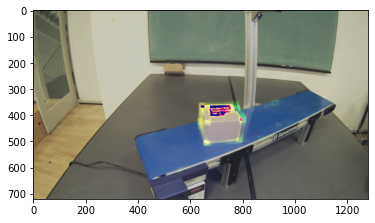

In [20]:
final=img2+ero2
plt.imshow(final)

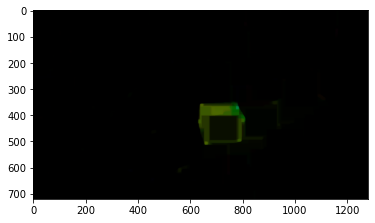

In [21]:
dia3=cv2.dilate(ero2,kernel,iterations=20)
ero3=cv2.erode(dia3,kernel,iterations=22)
plt.imshow(ero3)

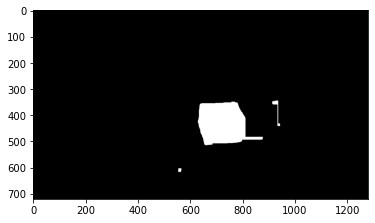

In [22]:
gray=cv2.cvtColor(ero3, cv2.COLOR_RGB2GRAY)
threshold = 10
threshold_value =255

thresh = cv2.threshold(gray, threshold, threshold_value, cv2.THRESH_BINARY)[1]
plt.imshow(thresh, cmap='gray')

In [37]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
#print(cnts)
text = "I found {} objects!".format(len(cnts))
print(text)
#print (cv2.contourArea(cnts[0]))
#print (cv2.contourArea(cnts[1]))
#print (cv2.contourArea(cnts[2]))
#print (cv2.contourArea(cnts[3]))
#print (cv2.contourArea(cnts[4]))

largest_area=0
current_area=0
index=0

for c in range(len(cnts)):
    current_area=cv2.contourArea(cnts[c])
    if current_area>largest_area:
        largest_area=current_area
        index=c
        
print(index)        

I found 3 objects!
1


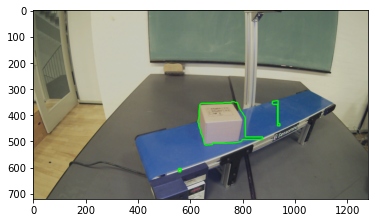

In [38]:
output = img2.copy()

for c in cnts:
    # draw each contour on the output image with a 3px thick black outline
    cv2.drawContours(output, [c], -1, (0, 255, 0), 3)

plt.imshow(output)

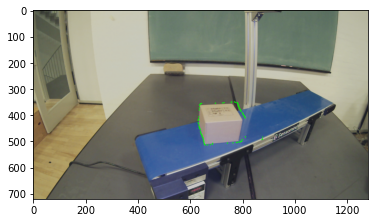

In [39]:
output = img2.copy()
for c in cnts[index]:
    # draw each contour on the output image with a 3px thick black outline
    cv2.drawContours(output, [c], -1, (0, 255, 0), 3)

plt.imshow(output)

In [40]:
cnt = cnts[index]
M = cv2.moments(cnt)
#print( M )
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx,cy)

723 432


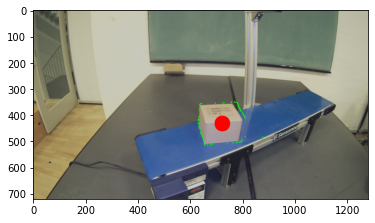

In [41]:
center_coordinates=(cx,cy)
circle=cv2.circle(output.copy(),center_coordinates,30,(255,0,0),cv2.FILLED)#circle --> center and radius also filled colour
plt.imshow(circle)

In [ ]:
# The initial state. The robot starts in position 0 with the velocity 0.
x = np.array([[0],
              [0]])

# The initial uncertainty. We start with some very large values.
P = np.array([[1000, 0],
              [0, 1000]])

# The external motion. Set to 0 here.
u = np.array([[0],
              [0]])

# The transition matrix. 
F = np.array([[1, 1],
              [0, 1]])

# The observation matrix. We only get the position as measurement.
H = np.array([[1, 0]])

# The measurement uncertainty
R = 1

# The identity matrix. Simply a matrix with 1 in the diagonal and 0 elsewhere.
I = np.array([[1, 0],
              [0, 1]])

# The measured position. The robot move 1 every time, but due to sensor uncertainties, we measure a bit off.
measurements = [1, 2.1, 2.9, 4.1, 5.0, 5.9, 7.1, 8.1]

def update(x, P, Z, H, R):
    # Insert update function
    Y = Z-H@x
    S = H@P@np.transpose(H) + R
    K = P@np.transpose(H)@np.linalg.pinv(S)
    x = x+K@Y
    P = (I-K@H)@P
    
    return [x,P]
    
def predict(x, P, F, u):
    ### insert predict function
    x = F@x + u
    P = F@P@np.transpose(F)
    
    return [x,P]
    
### Loop through the measurements ###
for i in range(0,len(measurements)):
    [x,P] = update(x, P, measurements[i], H, R)
    [x,P] = predict(x, P, F, u)
    



In [ ]:
x = np.array([[0], # Position along the x-axis
              [0], # Velocity along the x-axis
              [0], # Position along the y-axis
              [0]])# Velocity along the y-axis

### Update the rest of the parameters 

# You can use the following measurements or come up with your own. 
measurements_x = [1, 2.1, 2.9, 4.1, 5.0, 5.9, 7.1]
measurements_y = [1, 1.45, 2.0, 2.55, 3, 3.5, 4.05]

for i in range(len(measurements_x)):
    z = np.array([[measurement_x[i]],
                  [measurement_y[i]]])
    ### Insert the rest